In [9]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
import matplotlib.patches as mpatches


Using 25 Fourier basis functions
Target coefficients computed. First 5: [ 0.9798801   0.0787666  -0.76391984 -0.06205444 -0.05465544]
Starting ergodic trajectory optimization...
Optimization completed. Success: False
Final cost: 0.006288
Total iterations: 59

Final ergodic metric: 0.001997
Target vs Final coefficients:
  k=[0 0]: target=0.9799, achieved=0.9800, diff=0.0001
  k=[1 0]: target=0.0788, achieved=0.0924, diff=0.0137
  k=[2 0]: target=-0.7639, achieved=-0.8109, diff=-0.0469
  k=[3 0]: target=-0.0621, achieved=-0.0372, diff=0.0249
  k=[4 0]: target=-0.0547, achieved=-0.0981, diff=-0.0434
  k=[0 1]: target=0.2578, achieved=0.2566, diff=-0.0011
  k=[1 1]: target=0.0722, achieved=0.0888, diff=0.0166
  k=[2 1]: target=-0.0170, achieved=-0.0484, diff=-0.0315
  k=[3 1]: target=-0.1062, achieved=-0.0773, diff=0.0290
  k=[4 1]: target=-0.3304, achieved=-0.3849, diff=-0.0544


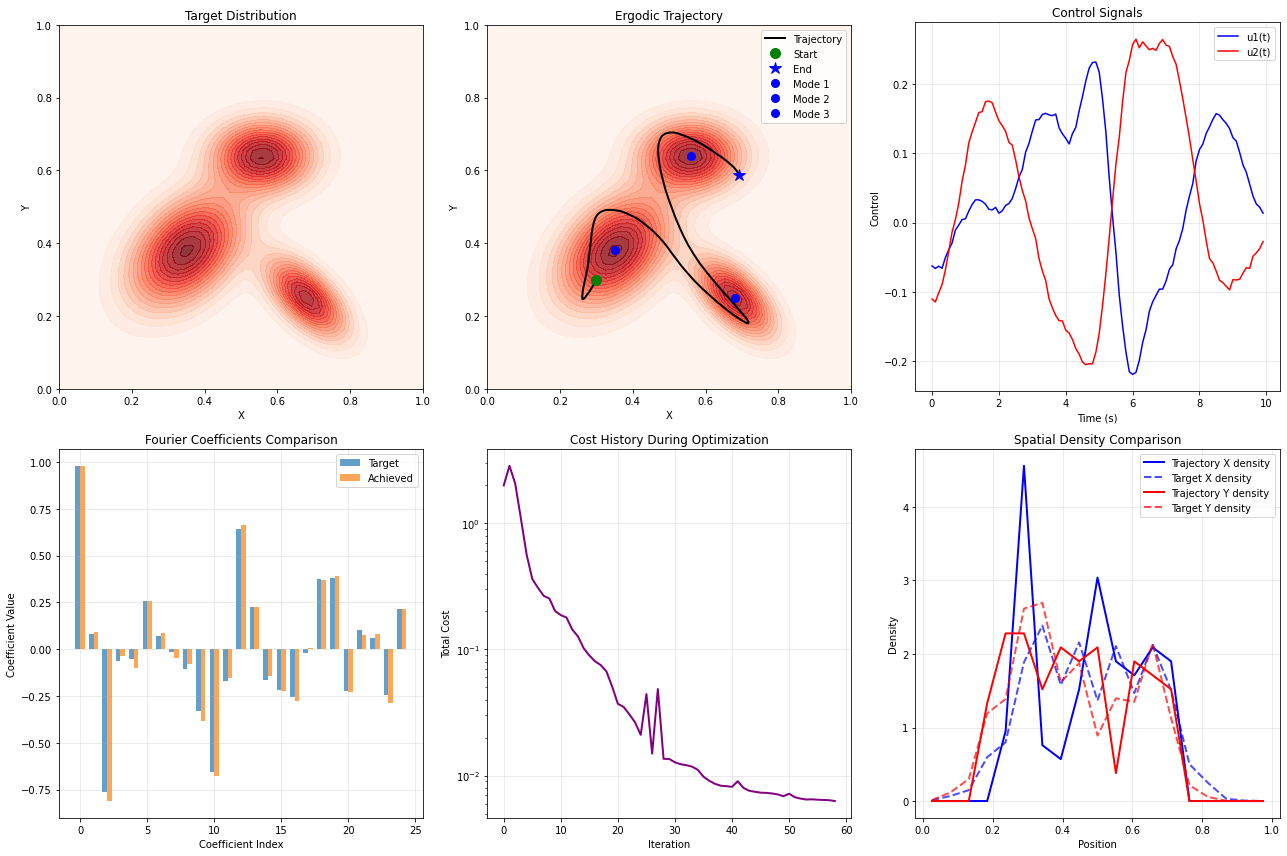


Control statistics:
u1 range: [-0.219, 0.232]
u2 range: [-0.205, 0.265]
Max |u|: 0.265
Ergodic metric: 0.001997
Cost reduction: 1.997932 -> 0.006288
Optimization converged in 59 iterations


In [13]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import multivariate_normal
from scipy.optimize import minimize

# --- 1. GMM Parameters (same as notebook) ---
w = [0.5, 0.2, 0.3]
mu = [np.array([0.35, 0.38]), np.array([0.68, 0.25]), np.array([0.56, 0.64])]
Sigma = [
    np.array([[0.01, 0.004], [0.004, 0.01]]),
    np.array([[0.005, -0.003], [-0.003, 0.005]]),
    np.array([[0.008, 0.0], [0.0, 0.004]])
]
gaussians = [multivariate_normal(mean=m, cov=s) for m, s in zip(mu, Sigma)]

def pdf(x):
    """GMM probability density function"""
    if x.ndim == 1:
        x = x.reshape(1, -1)
    pdf_val = 0
    for weight, gauss in zip(w, gaussians):
        pdf_val += weight * gauss.pdf(x)
    return pdf_val

# --- 2. Fourier Basis Setup (following notebook exactly) ---
L_list = np.array([1.0, 1.0])  # Domain boundaries
num_k_per_dim = 5  # Reduced for stability
ks_dim1, ks_dim2 = np.meshgrid(
    np.arange(num_k_per_dim), np.arange(num_k_per_dim)
)
ks = np.array([ks_dim1.ravel(), ks_dim2.ravel()]).T  # Index vectors

print(f"Using {ks.shape[0]} Fourier basis functions")

# --- 3. Target Distribution Coefficients (notebook method) ---
# Discretize the search space
grid_size = 50
grids_x, grids_y = np.meshgrid(
    np.linspace(0, L_list[0], grid_size),
    np.linspace(0, L_list[1], grid_size)
)
grids = np.array([grids_x.ravel(), grids_y.ravel()]).T
dx = dy = 1.0 / (grid_size - 1)

# Compute target coefficients using the notebook's exact method
coefficients = np.zeros(ks.shape[0])
for i, k_vec in enumerate(ks):
    # Evaluate fourier basis function over all grid cells
    fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1)
    hk = np.sqrt(np.sum(np.square(fk_vals)) * dx * dy)  # Normalization term
    fk_vals /= hk
    
    # Evaluate spatial probability density function over all grid cells
    pdf_vals = pdf(grids)
    
    # Approximate the integral through Riemann sum
    phik = np.sum(fk_vals * pdf_vals) * dx * dy
    coefficients[i] = phik

print(f"Target coefficients computed. First 5: {coefficients[:5]}")

# --- 4. Trajectory Optimization ---
dt = 0.1
T_horizon = 10.0
tlist = np.arange(0, T_horizon, dt)
N_steps = len(tlist)
x0 = np.array([0.3, 0.3])

def trajectory_from_controls(u_flat):
    """Convert flat control vector to trajectory"""
    u_traj = u_flat.reshape(N_steps, 2)
    x_traj = np.zeros((N_steps + 1, 2))
    x_traj[0] = x0.copy()
    
    for t in range(N_steps):
        x_next = x_traj[t] + dt * u_traj[t]
        x_traj[t+1] = np.clip(x_next, 0, 1)  # Keep in bounds
    
    return x_traj, u_traj

def calculate_trajectory_coefficients(x_traj):
    """Calculate trajectory coefficients using notebook method"""
    traj_coefficients = np.zeros(ks.shape[0])
    
    for i, k_vec in enumerate(ks):
        # Evaluate basis function over the trajectory
        fk_vals = np.prod(np.cos(np.pi * k_vec / L_list * x_traj[:-1]), axis=1)
        hk = np.sqrt(np.sum(np.square(np.prod(np.cos(np.pi * k_vec / L_list * grids), axis=1))) * dx * dy)
        fk_vals /= hk
        
        # Approximate integral through Riemann sum
        ck = np.sum(fk_vals) * dt / (N_steps * dt)
        traj_coefficients[i] = ck
    
    return traj_coefficients

def ergodic_objective(u_flat):
    """Ergodic optimization objective following notebook"""
    x_traj, u_traj = trajectory_from_controls(u_flat)
    
    # Calculate trajectory coefficients
    traj_coeffs = calculate_trajectory_coefficients(x_traj)
    
    # Ergodic metric (following notebook exactly)
    lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
    erg_cost = np.sum(lamk_list * np.square(coefficients - traj_coeffs))
    
    # Light regularization
    ctrl_cost = 0.01 * np.sum(u_traj**2) * dt
    smooth_cost = 0.01 * np.sum(np.diff(u_traj, axis=0)**2)
    
    total_cost = erg_cost + ctrl_cost + smooth_cost
    
    return total_cost

def ergodic_gradient(u_flat):
    """Numerical gradient"""
    grad = np.zeros_like(u_flat)
    eps = 1e-6
    
    f0 = ergodic_objective(u_flat)
    
    for i in range(len(u_flat)):
        u_plus = u_flat.copy()
        u_plus[i] += eps
        f_plus = ergodic_objective(u_plus)
        grad[i] = (f_plus - f0) / eps
    
    return grad

# --- 5. Optimization ---
print("Starting ergodic trajectory optimization...")

# Initialize with small random controls
np.random.seed(42)
u_init = 0.05 * np.random.randn(N_steps * 2)

# Control bounds
bounds = [(-1.0, 1.0) for _ in range(N_steps * 2)]

# Track cost history during optimization
cost_history = []

def objective_with_history(u_flat):
    cost = ergodic_objective(u_flat)
    cost_history.append(cost)
    return cost

# Run optimization
result = minimize(
    objective_with_history,
    u_init,
    method='L-BFGS-B',
    jac=ergodic_gradient,
    bounds=bounds,
    options={'maxiter': 50, 'disp': True}
)

print(f"Optimization completed. Success: {result.success}")
print(f"Final cost: {result.fun:.6f}")
print(f"Total iterations: {len(cost_history)}")

# --- 6. Extract and Analyze Results ---
u_opt = result.x
x_final_traj, u_final_traj = trajectory_from_controls(u_opt)

# Calculate final ergodic performance
traj_coeffs_final = calculate_trajectory_coefficients(x_final_traj)
lamk_list = np.power(1.0 + np.linalg.norm(ks, axis=1), -3/2.0)
final_ergodic_metric = np.sum(lamk_list * np.square(coefficients - traj_coeffs_final))

print(f"\nFinal ergodic metric: {final_ergodic_metric:.6f}")
print("Target vs Final coefficients:")
for i, (k, phi, c) in enumerate(zip(ks[:10], coefficients[:10], traj_coeffs_final[:10])):
    print(f"  k={k}: target={phi:.4f}, achieved={c:.4f}, diff={c-phi:.4f}")

# --- 7. Visualization ---
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Original PDF
ax = axes[0, 0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.set_title('Target Distribution')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_aspect('equal')

# Trajectory on PDF
ax = axes[0, 1]
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.8)
ax.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')
for i, mean in enumerate(mu):
    ax.plot(mean[0], mean[1], 'bo', markersize=8, label=f'Mode {i+1}')
ax.set_title('Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# Control signals
ax = axes[0, 2]
ax.plot(tlist, u_final_traj[:, 0], 'b-', lw=1.5, label='u1(t)')
ax.plot(tlist, u_final_traj[:, 1], 'r-', lw=1.5, label='u2(t)')
ax.set_title('Control Signals')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control')
ax.legend()
ax.grid(True, alpha=0.3)

# Coefficient comparison
ax = axes[1, 0]
indices = np.arange(len(coefficients))
width = 0.35
ax.bar(indices - width/2, coefficients, width, label='Target', alpha=0.7)
ax.bar(indices + width/2, traj_coeffs_final, width, label='Achieved', alpha=0.7)
ax.set_title('Fourier Coefficients Comparison')
ax.set_xlabel('Coefficient Index')
ax.set_ylabel('Coefficient Value')
ax.legend()
ax.grid(True, alpha=0.3)

# PDF values along trajectory
ax = axes[1, 1]
if len(cost_history) > 1:
    ax.plot(range(len(cost_history)), cost_history, 'purple', lw=2)
    ax.set_title('Cost History During Optimization')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Total Cost')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')  # Log scale for better visualization
else:
    ax.text(0.5, 0.5, 'No cost history available', ha='center', va='center', transform=ax.transAxes)
    ax.set_title('Cost History')

# Trajectory density comparison (both X and Y)
ax = axes[1, 2]
# Create density comparison for both dimensions
time_bins = np.linspace(0, 1, 20)

# X-direction densities
x_hist, _ = np.histogram(x_final_traj[:-1, 0], bins=time_bins, density=True)
x_target_hist, _ = np.histogram(grids[:, 0], bins=time_bins, weights=pdf_vals, density=True)

# Y-direction densities  
y_hist, _ = np.histogram(x_final_traj[:-1, 1], bins=time_bins, density=True)
y_target_hist, _ = np.histogram(grids[:, 1], bins=time_bins, weights=pdf_vals, density=True)

bin_centers = (time_bins[:-1] + time_bins[1:]) / 2

# Plot both dimensions
ax.plot(bin_centers, x_hist, 'b-', lw=2, label='Trajectory X density')
ax.plot(bin_centers, x_target_hist, 'b--', lw=2, alpha=0.7, label='Target X density')
ax.plot(bin_centers, y_hist, 'r-', lw=2, label='Trajectory Y density')
ax.plot(bin_centers, y_target_hist, 'r--', lw=2, alpha=0.7, label='Target Y density')

ax.set_title('Spatial Density Comparison')
ax.set_xlabel('Position')
ax.set_ylabel('Density')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Final statistics
print(f"\nControl statistics:")
print(f"u1 range: [{np.min(u_final_traj[:, 0]):.3f}, {np.max(u_final_traj[:, 0]):.3f}]")
print(f"u2 range: [{np.min(u_final_traj[:, 1]):.3f}, {np.max(u_final_traj[:, 1]):.3f}]")
print(f"Max |u|: {np.max(np.abs(u_final_traj)):.3f}")

# Ergodic performance metrics
print(f"Ergodic metric: {final_ergodic_metric:.6f}")
if len(cost_history) > 1:
    print(f"Cost reduction: {cost_history[0]:.6f} -> {cost_history[-1]:.6f}")
    print(f"Optimization converged in {len(cost_history)} iterations")

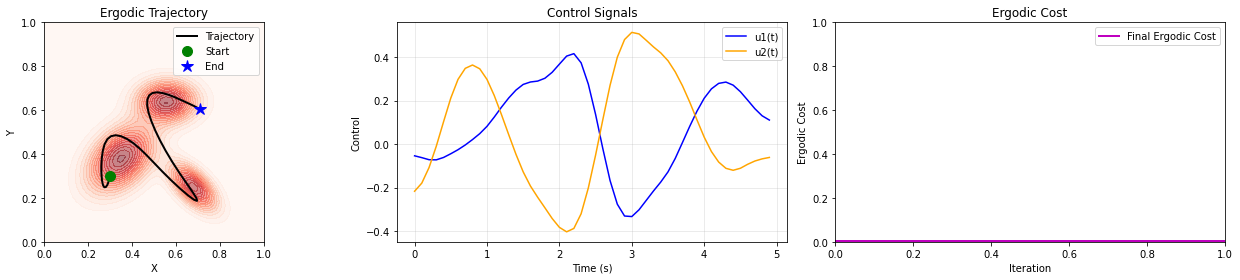

In [ ]:
# --- Plot: Ergodic Trajectory, Control Signals, and Ergodic Cost History Only ---

fig, axes = plt.subplots(1, 3, figsize=(18, 4))

# 1. Ergodic Trajectory
ax = axes[0]
pdf_vals = pdf(grids)
ax.contourf(grids_x, grids_y, pdf_vals.reshape(grids_x.shape), levels=20, cmap='Reds', alpha=0.5)
ax.plot(x_final_traj[:, 0], x_final_traj[:, 1], 'k-', lw=2, label='Trajectory')
ax.plot(x0[0], x0[1], 'go', markersize=10, label='Start')
ax.plot(x_final_traj[-1, 0], x_final_traj[-1, 1], 'b*', markersize=12, label='End')
ax.set_title('Ergodic Trajectory')
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.legend()
ax.set_aspect('equal')

# 2. Control Signals
ax = axes[1]
ax.plot(tlist, u_final_traj[:, 0], color='blue', lw=1.5, label='u1(t)')
ax.plot(tlist, u_final_traj[:, 1], color='orange', lw=1.5, label='u2(t)')
ax.set_title('Control Signals')
ax.set_xlabel('Time (s)')
ax.set_ylabel('Control')
ax.legend()
ax.grid(True, alpha=0.3)

# 3. Ergodic Cost History
ax = axes[2]
if len(cost_history) > 1:
    ax.plot(range(len(cost_history)), cost_history, color='m', lw=2)
    ax.set_title('Ergodic Cost History')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Ergodic Cost')
    ax.grid(True, alpha=0.3)
    ax.set_yscale('log')
else:
    ax.axhline(final_ergodic_metric, color='m', lw=2, label='Final Ergodic Cost')
    ax.set_title('Ergodic Cost')
    ax.set_xlabel('Iteration')
    ax.set_ylabel('Ergodic Cost')
    ax.legend()

plt.tight_layout()
plt.show()